In [439]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import io, signal, stats
import sys, os
sys.path.append('../')

from nlds.data_utils import load_mouse_data, sim_lorenz
from nlds.plotting import plot_trajectory
from nlds.edm_wrap import iterPredDim
import nlds.delayembed as de
import pyEDM as edm
import pandas as pd
from sklearn.decomposition import PCA
from fooof import FOOOFGroup


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def iterPredDim(dataframe,lib_inds,pred_inds, Tps, maxdim, tau=1):
    # iterate through all configurations of prediction horizon and embedding dimensions
    dfs = []
    for Tp in Tps:
        dfs.append(edm.EmbedDimension(dataFrame=dataframe, lib=lib_inds, pred=pred_inds, maxE=maxdim, tau=tau, Tp=Tp, columns="X", target="X", showPlot=False))

    df_res = pd.DataFrame(np.array([df['rho'].values for df in dfs]), index=Tps, columns=np.arange(1,maxdim+1))
    return df_res


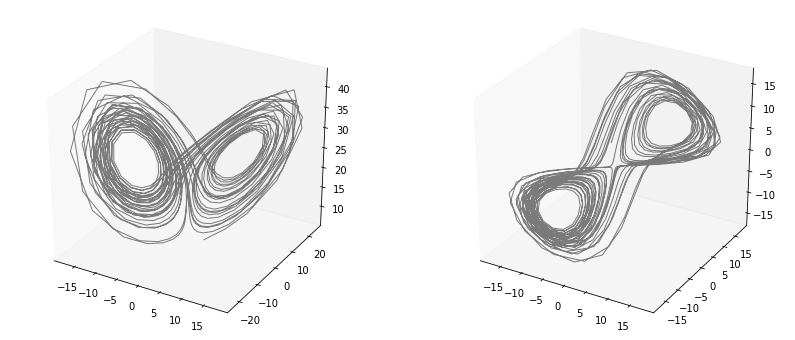

In [88]:
tau = 2
T, fs = 40, 20
xinit = np.random.randint(0,10,size=3)
la = sim_lorenz(T, fs, xinit)
x_embed = de.delay_embed(la[0],tau,3)
plt.figure(figsize=(14,6))
ax = plt.subplot(1,2,1, projection='3d')
plot_trajectory(np.array(la).T, ax, alpha=0.5);
ax = plt.subplot(1,2,2, projection='3d')
plot_trajectory(x_embed, ax, alpha=0.5);

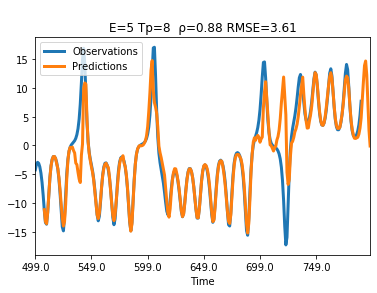

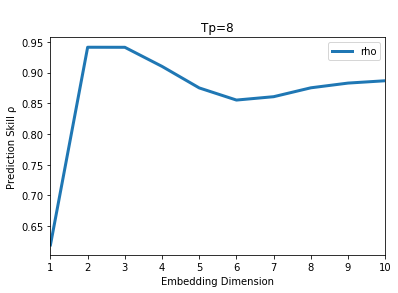

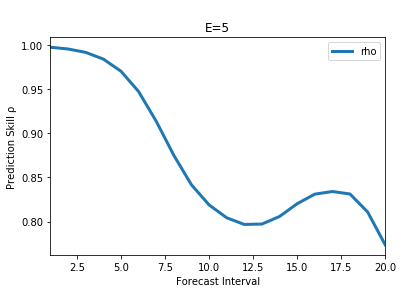

In [117]:
tau, dim, Tp = 2, 5, 8

x = la[0]
split_ind = 500
lib_inds = '0 %s'%split_ind
pred_inds = '%s %s'%(split_ind, len(x)-tau*dim)
df_lorenzX = pd.DataFrame(np.array([np.arange(0, len(x)).astype(int), x]).T, columns=['Time','X'])
df_pred = edm.Simplex(dataFrame=df_lorenzX, lib = lib_inds, pred = pred_inds,  E=dim, tau=tau, Tp=Tp, showPlot = True, const_pred = True, columns="X", target="X");

maxdim=10
lib_inds = '0 %s'%split_ind
pred_inds = '%s %s'%(split_ind, len(x)-tau*maxdim)
df_dim = edm.EmbedDimension(dataFrame=df_lorenzX, lib = lib_inds, pred = pred_inds,  maxE=maxdim, tau=tau, Tp=Tp, columns="X", target="X")

maxTp=20
df_Tp = edm.PredictInterval(dataFrame=df_lorenzX, lib = lib_inds, pred = pred_inds,  maxTp=maxTp, E=dim, tau=tau, columns="X", target="X")

In [3]:
maxdim=15
tau=2
Tps = np.arange(1,11)
df_corr = iterPredDim(df_lorenzX,lib_inds,pred_inds, Tps, maxdim=maxdim, tau=tau)

In [3]:
datafolder = '/Users/rdgao/Documents/data/Stringer_neuropixel/spikes/'
#df_spk, df_info = load_mouse_data(datafolder, 0, return_type='smoothed', bin_width=0.1, smooth_param=[2,0.2])

mice = ['Krebs', 'Waksman', 'Robbins']
i_m = 0
df_spk, df_info = load_mouse_data(datafolder, i_m, return_type='binned', bin_width=1)


Grabbing Spikes...
Binning Spikes...


### compute acf for all spikes

In [58]:
maxlag=100
df_acf = pd.DataFrame(columns=df_spk.columns)
for cell, col in df_spk.iteritems():
    print(cell, end='|')
    acf = np.zeros(maxlag+1)
    for lag in range(0,maxlag+1):
        acf[lag] = df_spk[cell].autocorr(lag=lag)

    df_acf[cell]=acf

df_acf.to_csv('../results/acf_1s/%s.csv'%mice[i_m])

all|V1|TH|SomMoCtx|SC|MB|LS|HPF|FrMoCtx|CP|0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91|92|93|94|95|96|97|98|99|100|101|102|103|104|105|106|107|108|109|110|111|112|113|114|115|116|117|118|119|120|121|122|123|124|125|126|127|128|129|130|131|132|133|134|135|136|137|138|139|140|141|142|143|144|145|146|147|148|149|150|151|152|153|154|155|156|157|158|159|160|161|162|163|164|165|166|167|168|169|170|171|172|173|174|175|176|177|178|179|180|181|182|183|184|185|186|187|188|189|190|191|192|193|194|195|196|197|198|199|200|201|202|203|204|205|206|207|208|209|210|211|212|213|214|215|216|217|218|219|220|221|222|223|224|225|226|227|228|229|230|231|232|233|234|235|236|237|238|239|240|241|242|243|244|245|246|247|248|249|250|251|252|253|254|255|256|257|258|259|260|261|262|263|264|265|266

In [6]:
datafolder = '/Users/rdgao/Documents/data/Stringer_neuropixel/spikes/'
mice = ['Krebs', 'Waksman', 'Robbins']
i_m = 0
df_spk, df_info = load_mouse_data(datafolder, i_m, return_type='binned', bin_width=1)

df_acf = pd.read_csv('../results/acf_1s/%s.csv'%mice[i_m])
taus = (df_acf>0.3).sum(0)

for cell in df_spk.columns:
    x = df_spk[cell].values
    df_data = pd.DataFrame(np.array([np.arange(0, len(x)).astype(int), x]).T, columns=['Time','X'])

    maxdim=10
    Tps = np.arange(1,11)
    split_ind = int(len(x)/2)
    lib_inds = '0 %s'%split_ind

    # do one with variable tau
    tau=np.min([taus[cell],20])
    print(cell, tau, end='-')
    pred_inds = '%s %s'%(split_ind, len(x)-20*maxdim-Tps[-1])
    df_corr = iterPredDim(df_data,lib_inds,pred_inds, Tps, maxdim=maxdim, tau=tau)
    df_corr.to_csv('../results/rate_embed/%/%s_tau-%i.csv'%(mice[i_m],cell,tau))

    tau=5
    print(cell, tau, end='|')
    pred_inds = '%s %s'%(split_ind, len(x)-tau*maxdim-Tps[-1])
    df_corr = iterPredDim(df_data,lib_inds,pred_inds, Tps, maxdim=maxdim, tau=tau)
    df_corr.to_csv('../results/rate_embed/%/%s_tau-%i.csv'%(mice[i_m],cell,tau))

Grabbing Spikes...
Binning Spikes...


all 20-all 5|V1 4-V1 5|TH 20-TH 5|SomMoCtx 4-SomMoCtx 5|SC 20-SC 5|MB 20-MB 5|LS 8-LS 5|HPF 20-HPF 5|FrMoCtx 4-FrMoCtx 5|CP 20-CP 5|0 20-0 5|1 20-1 5|2 4-2 5|3 20-3 5|4 4-4 5|5 20-5 5|6 20-6 5|7 8-7 5|8 20-8 5|9 4-9 5|10 20-10 5|11 1-11 5|12 2-12 5|13 2-13 5|14 5-14 5|15 2-15 5|16 7-16 5|17 2-17 5|18 6-18 5|19 2-19 5|20 2-20 5|21 14-21 5|22 20-22 5|23 1-23 5|24 1-24 5|25 1-25 5|26 1-26 5|27 17-27 5|28 20-28 5|29 3-29 5|30 20-30 5|31 1-31 5|32 1-32 5|33 1-33 5|34 2-34 5|35 16-35 5|36 4-36 5|37 6-37 5|38 5-38 5|39 3-39 5|40 1-40 5|41 2-41 5|42 3-42 5|43 20-43 5|44 2-44 5|45 5-45 5|46 1-46 5|47 10-47 5|48 2-48 5|49 2-49 5|50 1-50 5|51 1-51 5|52 1-52 5|53 3-53 5|54 1-54 5|55 2-55 5|56 4-56 5|57 1-57 5|58 1-58 5|59 3-59 5|60 3-60 5|61 13-61 5|62 1-62 5|63 1-63 5|64 1-64 5|65 2-65 5|66 2-66 5|67 2-67 5|68 6-68 5|69 3-69 5|70 1-70 5|71 1-71 5|72 3-72 5|73 1-73 5|74 1-74 5|75 1-75 5|76 3-76 5|77 2-77 5|78 2-78 5|79 2-79 5|80 1-80 5|81 1-81 5|82 1-82 5|83 1-83 5|84 1-84 5|85 2-85 5|86 1-86 5|87

-680 5|681 17-681 5|682 2-682 5|683 1-683 5|684 2-684 5|685 1-685 5|686 1-686 5|687 4-687 5|688 1-688 5|689 1-689 5|690 1-690 5|691 20-691 5|692 12-692 5|693 20-693 5|694 1-694 5|695 2-695 5|696 2-696 5|697 1-697 5|698 3-698 5|699 2-699 5|700 2-700 5|701 1-701 5|702 5-702 5|703 1-703 5|704 2-704 5|705 1-705 5|706 1-706 5|707 20-707 5|708 2-708 5|709 1-709 5|710 1-710 5|711 1-711 5|712 1-712 5|713 1-713 5|714 11-714 5|715 1-715 5|716 2-716 5|717 1-717 5|718 1-718 5|719 3-719 5|720 1-720 5|721 1-721 5|722 20-722 5|723 1-723 5|724 1-724 5|725 2-725 5|726 1-726 5|727 3-727 5|728 1-728 5|729 1-729 5|730 1-730 5|731 2-731 5|732 1-732 5|733 2-733 5|734 1-734 5|735 1-735 5|736 2-736 5|737 2-737 5|738 1-738 5|739 2-739 5|740 2-740 5|741 1-741 5|742 6-742 5|743 2-743 5|744 2-744 5|745 4-745 5|746 2-746 5|747 1-747 5|748 2-748 5|749 2-749 5|750 2-750 5|751 9-751 5|752 2-752 5|753 19-753 5|754 6-754 5|755 1-755 5|756 2-756 5|757 1-757 5|758 1-758 5|759 17-759 5|760 3-760 5|761 10-761 5|762 1-762 5

-1302 5|1303 1-1303 5|1304 1-1304 5|1305 1-1305 5|1306 1-1306 5|1307 2-1307 5|1308 2-1308 5|1309 2-1309 5|1310 1-1310 5|1311 2-1311 5|1312 1-1312 5|1313 2-1313 5|1314 20-1314 5|1315 20-1315 5|1316 1-1316 5|1317 1-1317 5|1318 20-1318 5|1319 1-1319 5|1320 20-1320 5|1321 7-1321 5|1322 20-1322 5|1323 20-1323 5|1324 20-1324 5|1325 2-1325 5|1326 20-1326 5|1327 2-1327 5|1328 20-1328 5|1329 20-1329 5|1330 20-1330 5|1331 2-1331 5|1332 1-1332 5|1333 8-1333 5|1334 20-1334 5|1335 20-1335 5|1336 20-1336 5|1337 20-1337 5|1338 20-1338 5|1339 7-1339 5|1340 2-1340 5|1341 20-1341 5|1342 20-1342 5|1343 8-1343 5|1344 20-1344 5|1345 20-1345 5|1346 20-1346 5|1347 20-1347 5|1348 20-1348 5|1349 5-1349 5|1350 2-1350 5|1351 3-1351 5|1352 1-1352 5|1353 3-1353 5|1354 17-1354 5|1355 20-1355 5|1356 20-1356 5|1357 20-1357 5|1358 1-1358 5|1359 11-1359 5|1360 20-1360 5|1361 7-1361 5|1362 4-1362 5|1363 20-1363 5|1364 20-1364 5|1365 20-1365 5|1366 20-1366 5|1367 20-1367 5|1368 20-1368 5|1369 2-1369 5|1370 20-1370 5|1371

In [367]:
result_path = '../results/rate_embed/%s/'%mice[i_m]
filenames = os.listdir(result_path)
df_res = []
for i_c, cell in enumerate(df_spk.columns):
#    df_res.append(pd.read_csv(result_path+'%s_tau-%s.csv'%(cell,np.min([taus[cell],20])), index_col=0))
    df_res.append(pd.read_csv(result_path+'%s_tau-5.csv'%cell, index_col=0))
    
# sum axis=0:dim , axis=1:Tp
df_Tp = pd.DataFrame(np.array([df_.mean(1) for df_ in df_res]).T, columns=df_spk.columns)
df_dim = pd.DataFrame(np.array([df_.mean(0) for df_ in df_res]).T, columns=df_spk.columns)

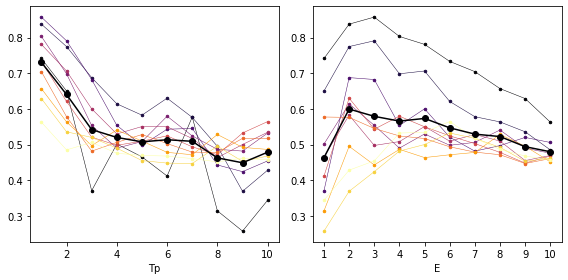

In [692]:
color = plt.cm.inferno(np.linspace(0,1,10))
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

df_corr = df_res[0]
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(df_corr,'.-', lw=0.5, ms=5)
plt.plot(df_corr.mean(1),'o-')
plt.xlabel('Tp')

plt.subplot(1,2,2)
plt.plot(df_corr.T,'.-', lw=0.5, ms=5)
plt.plot(df_corr.mean(0),'o-')
plt.xlabel('E')
plt.tight_layout()

In [628]:
def return_pops(df_data, df_info):
    pop_list, region_labels = [], []
    for reg, grp in df_info.groupby('region'):
        pop_list.append(np.squeeze(df_data[grp.index.values].values))
        region_labels.append(reg)
    return pop_list, region_labels

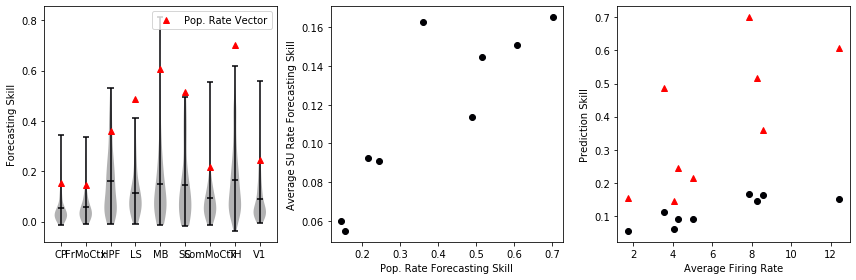

In [649]:
color = plt.cm.inferno(np.linspace(0,1,len(region_labels)))
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

df_plot = df_dim
max_pool = []
mean_pool = []
region_labels = []
tau_pool = []
num_cells = []
for reg, grp in df_info.groupby('region'):
    region_labels.append(reg)
    max_pool.append(df_plot[grp.index.values].max().values)
    mean_pool.append(df_plot[grp.index.values].mean().values)
    tau_pool.append(taus[11:][grp.index.values].mean())
    num_cells.append(len(grp))

# mean over population rates
agg_pop = df_plot[region_labels].mean(0).values

# mean over pooled single unit rates
agg_su = [mp.mean() for mp in mean_pool]
        
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(agg_pop, 'r^', label='Pop. Rate Vector')
plt.legend()
#plt.plot(agg_su, 'o')

plt.violinplot(mean_pool, np.arange(len(mean_pool)), showmeans=True)
plt.xticks(np.arange(len(mean_pool)), region_labels)
plt.ylabel('Forecasting Skill')


plt.subplot(1,3,2)
plt.plot(agg_pop, agg_su, 'o')
plt.xlabel('Pop. Rate Forecasting Skill')
plt.ylabel('Average SU Rate Forecasting Skill');

plt.subplot(1,3,3)
# plt.plot(taus[region_labels], agg_pop, 'r^')
# plt.plot(tau_pool, agg_su, 'o')
# plt.xscale('log')

#plt.plot(num_cells, agg_su, 'o')
#plt.plot(num_cells, agg_pop, 'r^')

plt.plot(df_spk[region_labels].mean()/num_cells, agg_pop, '^r')
plt.plot(df_spk[region_labels].mean()/num_cells, agg_su, 'o')
plt.xlabel('Average Firing Rate'); plt.ylabel('Prediction Skill')
# embedding dim
# PCA
plt.tight_layout()

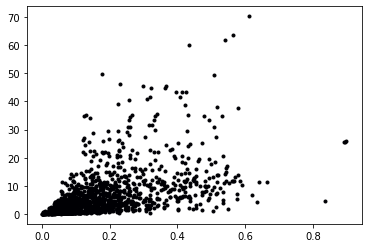

In [673]:
# comparing single unit average firing rate with forecast skill
plt.plot(np.max(df_plot[df_plot.columns[10:]],0).values, df_spk[df_plot.columns[10:]].mean(0).values, '.')

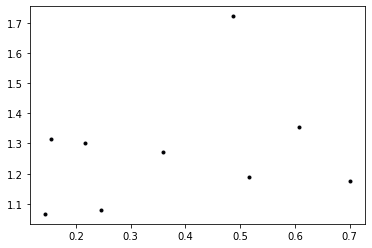

In [675]:
# population forecast skill vs. PSD slope
plt.plot(agg_pop, df_pca_exp[region_labels].loc['pca_exp'], '.')

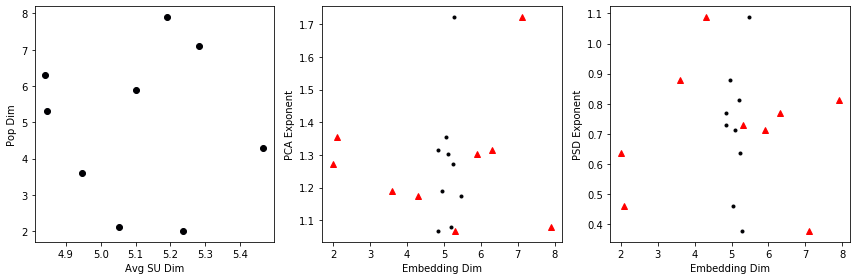

In [745]:
# population embedding dimension vs pca/psd exponent

df_embed_dim = pd.DataFrame(np.array([df_.index[np.argmax(df_.values,1)].values for df_ in df_res]).T, columns=df_spk.columns)
dim_list, _ = return_pops(df_embed_dim.mean(0), df_info)
avg_SU_dim = [d_.mean() for d_ in dim_list]
agg_dim = np.mean(df_embed_dim[region_labels], 0)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(avg_SU_dim, agg_dim, 'o')
plt.xlabel('Avg SU Dim'); plt.ylabel('Pop Dim');
plt.subplot(1,3,2)
plt.plot(agg_dim, df_pca_exp[region_labels].loc['pca_exp'], 'r^')
plt.plot(avg_SU_dim, df_pca_exp[region_labels].loc['pca_exp'], '.')
plt.xlabel('Embedding Dim'); plt.ylabel('PCA Exponent')

plt.subplot(1,3,3)
plt.plot(agg_dim, df_psd_exp[region_labels].loc['psd_exp'], 'r^')
plt.plot(avg_SU_dim, df_psd_exp[region_labels].loc['psd_exp'], '.')
plt.xlabel('Embedding Dim'); plt.ylabel('PSD Exponent')
plt.tight_layout()

# Fitting PCA and power spectrum

Running FOOOFGroup across 1472 power spectra.
Running FOOOFGroup across 10 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(-0.7224450582859999, 0.018276810263368814)


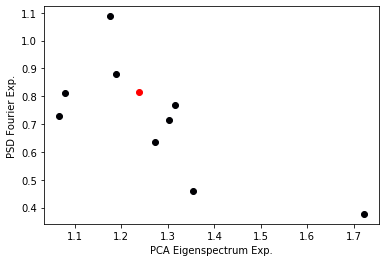

In [640]:
# power spectrum
nperseg, noverlap = 100, 75
faxis, psd = signal.welch(df_spk.T, nperseg=nperseg, noverlap=noverlap)
fg = FOOOFGroup(max_n_peaks=1, aperiodic_mode='fixed')
fg.fit(faxis, psd, [0.04, 0.2])
psd_exp = fg.get_params('aperiodic_params', 'exponent')
df_psd_exp = pd.DataFrame(psd_exp[None,:], columns=df_spk.columns, index=['psd_exp'])

# pca
n_pc_max = 30
pca_pool = []
fit_pool = []
i_=0
for reg, grp in df_info.groupby('region'):
    n_pc = n_pc_max #np.min((n_pc_max, len(grp)))
    pop_pca = PCA(n_pc).fit(df_spk[grp.index].values)
    pca_pool.append(pop_pca.explained_variance_ratio_)
pca_pool = np.array(pca_pool)

# all population
pop_pca = PCA(n_pc).fit(df_spk[df_spk.columns[10:]].values)
pca_pool = np.concatenate((pop_pca.explained_variance_ratio_[None,:], pca_pool))

fg_pca = FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed')
fg_pca.fit(freqs=np.arange(1,n_pc_max+1), power_spectra=pca_pool)
pca_exp = fg_pca.get_params('aperiodic_params', 'exponent')
df_pca_exp = pd.DataFrame(pca_exp[None,:], columns=df_spk.columns[0:10], index=['pca_exp'])

plt.plot(df_pca_exp[region_labels].loc['pca_exp'], df_psd_exp[region_labels].loc['psd_exp'], 'o')
plt.plot(df_pca_exp['all'].loc['pca_exp'], df_psd_exp['all'].loc['psd_exp'], 'or')
print(stats.pearsonr(df_pca_exp[df_pca_exp.columns].loc['pca_exp'], df_psd_exp[df_pca_exp.columns].loc['psd_exp']))
plt.xlabel('PCA Eigenspectrum Exp.')
plt.ylabel('PSD Fourier Exp.');

#plt.plot(agg_pop, df_pca_exp.values.T, 'o')
#plt.plot(num_cells, df_pca_exp.loc['pca_exp'], 'o')
#plt.plot(agg_pop, pca_pool[:,1], 'o')
#plt.plot(num_cells, fit_pool[:,0], '.')
#stats.pearsonr(agg_pop, fit_pool[:,0])

(0.33397640055382083, 0.3797378705968368)

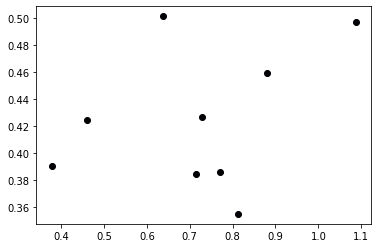

In [639]:
psd_exp_list, region_labels = return_pops(df_psd_exp, df_info)
psd_exp_su = [np.mean(e) for e in psd_exp_list]
df_psd_exp_su = pd.DataFrame(np.array(psd_exp_su)[:,None].T, columns=df_spk.columns[1:10], index=['psd_exp_su'])

# pop rate psd exp vs. avg single unit psd exp
x, y = df_psd_exp[region_labels].loc['psd_exp'], df_psd_exp_su[region_labels].loc['psd_exp_su']

plt.plot(x, y, 'o')
stats.pearsonr(x,y)

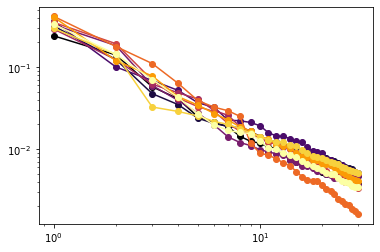

In [746]:
plt.loglog(np.arange(1, n_pc+1),pca_pool.T, 'o-')

# stuff to try

analyses
- embedding dim (nonlinearity test)
    - pop vs unit avg
    - vs PCA dim
        - worked in mouse 1, but not 2 and 3
- single unit rate vs. pop rate vs. pca power law
    - pop rate PSD exp correlates with PCA exp
    - avg single unit rate PSD exp does NOT correlate with pop rate exp or PCA exp
        - how many neurons do you need?
    
- embedding PCA (SSA)
    - has some relationship with PSD, but not pop PCA (see spacetime_spectrum)
- 2D FT?

controls
- subsample population to do PCA
    - PCA spectrum exponent scales with number of units, why?
- shuffling:
    - circshift neurons in time and measure population exponent via PCA and pop rate (preserves neuron temporal stats)
    - shuffle time points and measure single unit and pop rate freq spectrum exponent (preserve PCA)
    - circshift neurons in space and measure (preserves pop freq rate spectrum)
    



    

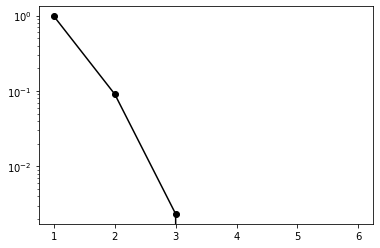

In [1221]:
tau=5
max_dim=6
dim, pfnn, del_R, rel_R = de.PFNN(la[1],tau,max_dim, return_dist=True)
plt.plot(np.arange(max_dim)+1, pfnn,'ko-', label='PFNN')
plt.yscale('log')

In [1145]:
datafolder = '/Users/rdgao/Documents/data/Stringer_neuropixel/spikes/'
#df_spk, df_info = load_mouse_data(datafolder, 0, return_type='smoothed', bin_width=0.1, smooth_param=[2,0.2])
df_spk, df_info = load_mouse_data(datafolder, 0, return_type='binned', bin_width=0.1)

Grabbing Spikes...
Binning Spikes...


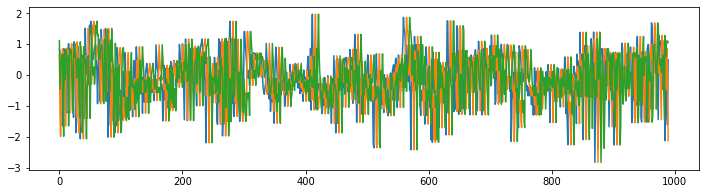

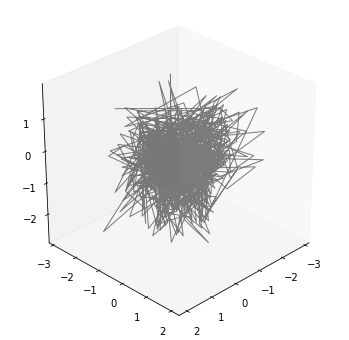

In [1228]:
pop_rate = stats.zscore(np.log10(df_spk.sum(1).values))
t = df_spk.index.values
#x_embed = de.delay_embed(np.log10(df_spk[0].values[0:10000]+1e-6),20,3)
#x_embed = de.delay_embed(df_spk[50].values[:5000],5,3)
x_embed = de.delay_embed(pop_rate[5000:6000],5,3)
plt.figure(figsize=(12,3))
plt.plot(x_embed)
plt.figure(figsize=(6,6))
ax = plot_trajectory(x_embed, step=1, alpha=0.5);
ax.view_init(elev=30., azim=45)

../nlds/delayembed.py:199: RuntimeWarning: divide by zero encountered in true_divide
  del_R[:, dim] = abs(ndist) / dist[:, 1]
../nlds/delayembed.py:199: RuntimeWarning: invalid value encountered in true_divide
  del_R[:, dim] = abs(ndist) / dist[:, 1]
../nlds/delayembed.py:199: RuntimeWarning: divide by zero encountered in true_divide
  del_R[:, dim] = abs(ndist) / dist[:, 1]
../nlds/delayembed.py:199: RuntimeWarning: invalid value encountered in true_divide
  del_R[:, dim] = abs(ndist) / dist[:, 1]


-1


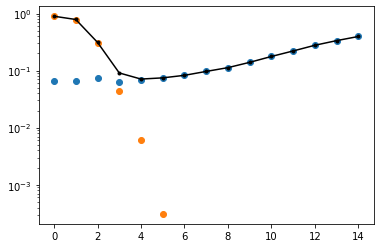

In [1229]:
tau=5
max_dim=15
x = pop_rate #pop rate
#x = np.log10(df_spk[600].values+1e-3)
dim, pfnn, del_R, rel_R = de.PFNN(x,tau,max_dim, return_dist=True)
print(dim)
plt.plot((rel_R>2).sum(0)/rel_R.shape[0], 'o', label='Distance Criteria')
plt.plot((del_R>15).sum(0)/rel_R.shape[0], 'o', label='Delta Criteria')
plt.plot(pfnn,'k.-', label='PFNN')
plt.yscale('log')

(6000,)


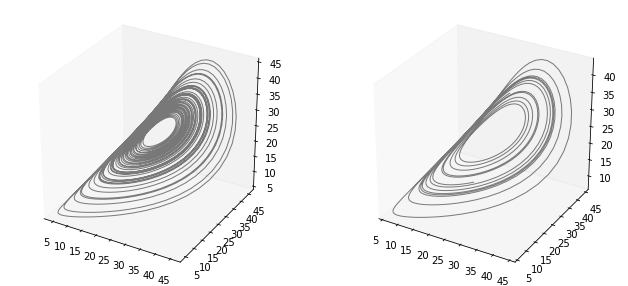

In [1477]:
#def delay_forecast(data_train, data_test, tau, max_dim=5):
#x = pop_rate
#x = np.random.randn(14000)
x = la[2]
print(x.shape)
data_train = x[:3000]
data_test = x[5000:]

tau = 5
max_dim = 10
n_neighbors = 5
n_ahead = 10

train_embed = de.delay_embed(data_train, tau, max_dim)
test_embed = de.delay_embed(data_test, tau, max_dim)

dim=3
# find knn at ith dimension
knn = NearestNeighbors(n_neighbors, algorithm='kd_tree')
knn.fit(train_embed[:-n_ahead, :dim])
dist, idx = knn.kneighbors(test_embed[:, :dim])

plt.figure(figsize=(11,5))
ax = plt.subplot(1,2,1, projection='3d')
plot_trajectory(train_embed[:,:3], ax, alpha=0.5);
ax = plt.subplot(1,2,2, projection='3d')
plot_trajectory(test_embed[:,:3], ax, alpha=0.5);

In [1478]:
test_embed[0,:dim]

array([28.70053866, 32.7031507 , 36.30540514])

In [1479]:
idx

array([[2838,  769, 2684, 2384, 2155],
       [2839, 2385, 2156, 2685,  770],
       [2840, 2157, 2386, 2312,  771],
       ...,
       [2128, 2357, 2656, 1485, 2657],
       [2129, 2358, 1486, 2657, 2658],
       [2130, 2359, 1487, 2659, 2658]])

array([21.88372087, 22.0545644 , 21.85864246, 21.96286084, 21.98444092])

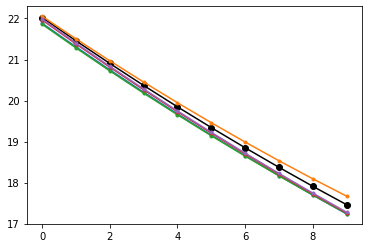

In [1480]:
test_ind = 10
plt.plot(test_embed[test_ind+np.arange(n_ahead),0],'ko-')
plt.plot(train_embed[idx[test_ind,:]+np.arange(n_ahead)[:,None],0], '.-')
# plt.plot(test_embed[test_ind+1+np.arange(n_ahead),0],'ko-')
# plt.plot(train_embed[idx[test_ind+1,:]+np.arange(n_ahead)[:,None],0], '.-')
# plt.plot(test_embed[test_ind+2+np.arange(n_ahead),0],'ko-')
# plt.plot(train_embed[idx[test_ind+2,:]+np.arange(n_ahead)[:,None],0], '.-')

train_embed[idx[test_ind,:],0]

In [1481]:
weights = np.exp(-dist/np.min(dist,1)[:,None])
pred = (weights*train_embed[idx][:,:,0]).sum(1)/weights.sum(1)
#test_embed.shape

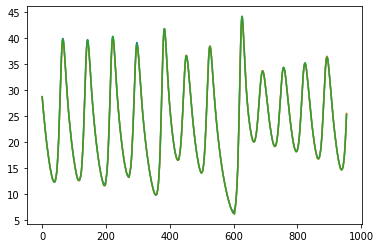

In [1484]:
# train_embed[idx+1,0]
# train_embed.shape[0]
# idx[idx>=train_embed.shape[0]-n_ahead]=np.nan
n_pred = 0
plt.plot(test_embed[n_pred:,0])
plt.plot(train_embed[idx+n_pred,0].mean(1))
plt.plot(pred)

#plt.plot(train_embed[idx+n_pred,0])
#plt.plot(train_embed[idx[0][0]:,0])
#plt.plot(train_embed[idx[0][1]:,0])
#plt.plot(train_embed[idx+n_pred,0].mean(1)[:-n_pred],test_embed[n_pred:,0])
#plt.plot(test_embed[:,0])
#idx[0][0]:
#plt.xlim([0,200])

In [1446]:
rho=[]
for n_pred in range(1,n_ahead+1):
    rho.append(stats.pearsonr(train_embed[idx+n_pred,0].mean(1)[:-n_pred],test_embed[n_pred:,0])[0])
    #rho.append(((train_embed[idx+n_pred,0].mean(1)[:-n_pred]-test_embed[n_pred:,0])**2).sum()**0.5)
plt.plot(rho,'o') 

[   8.90618592  -36.40536267   90.01317749 -149.17153933  173.20057376
 -142.71451663   82.40062037  -31.89691518    7.47137998   -0.80360376]


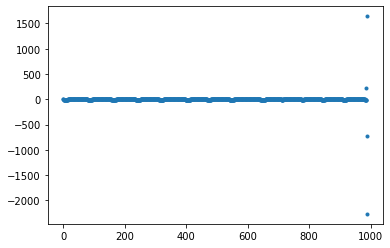

In [1565]:
maxlag=10#tau*dim
ar_model=AR(data_train)
ar_fit = ar_model.fit(maxlag, trend='nc')
print(ar_fit.params)
ar_pred = np.convolve(data_test, ar_fit.params, 'same')
plt.plot(data_test-ar_pred,'.')
# plt.plot(data_test[maxlag-1:])
# plt.plot(ar_pred)

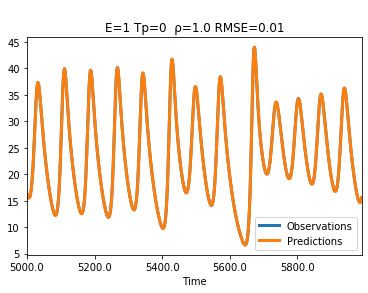

In [1487]:
df_lorenzX = pd.DataFrame(np.array([np.arange(1, len(x)+1).astype(int), x]).T, columns=['Time','X'])
#df_lorenzX = pd.DataFrame(np.array([np.arange(1, len(pop_rate)+1).astype(int), pop_rate]).T, columns=['Time','X'])
#edm.Simplex()
edm.Simplex(dataFrame = df_lorenzX, lib = "1 3000", pred = "5000 5990",  E=1, tau=tau, Tp=0, knn=5, showPlot = True, const_pred = True, columns="X", target="X");



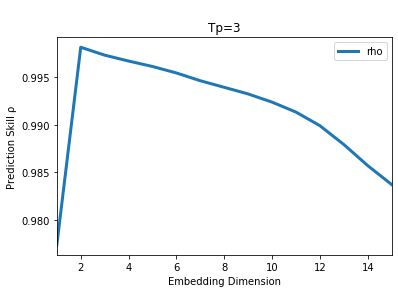

,E,rho
0,1.0,0.977390
1,2.0,0.998143
2,3.0,0.997312
3,4.0,0.996695
4,5.0,0.996122
5,6.0,0.995444
6,7.0,0.994625
7,8.0,0.993936
8,9.0,0.993239
9,10.0,0.992380


In [1472]:
edm.EmbedDimension(dataFrame = df_lorenzX, lib = "1 3000", pred = "5000 5900", columns="X", target="X", tau=5, maxE=15, Tp=3)